# Challenge 6: Where There is Smoke


## Image Classification


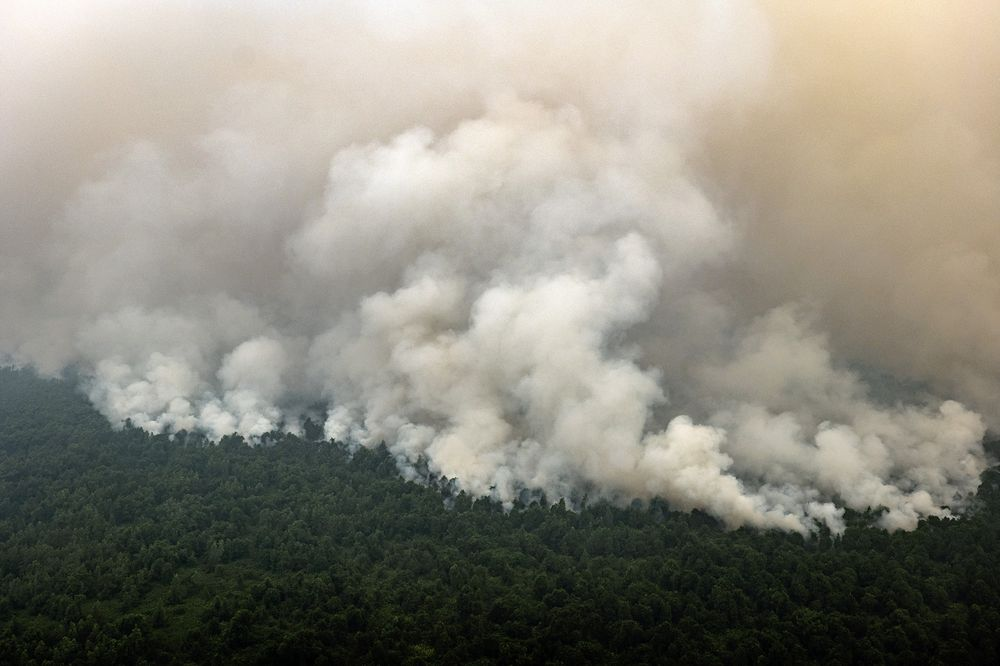




In [ ]:
import os
root_path = os.getcwd()

In [ ]:
import zipfile
from ibm_botocore.client import Config
import ibm_boto3
import time

In [ ]:
credentials_1 = {
    'IAM_SERVICE_ID': 'Auto-generated for key 15c2aba7-715b-4157-9d81-0075b207c5ec',
    'IBM_API_KEY_ID': 'MHYDZ0jZYSqDgr9tDKhCQMiZmbX_WhYoEF-GAeqvCyf2',
    'ENDPOINT': 'https://s3.ap.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'watson-warrior-alpha',
    'FILE': 'data_asset/wt_big_sur_sat_data_2016.csv_shaped_f35c000b.csv'
}

In [ ]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_1['ENDPOINT'])

In [ ]:
cos.download_file(Bucket=credentials_1['BUCKET'],Key='FIRE-SMOKE-DATASET.zip',Filename='FIRE-SMOKE-DATASET.zip')
cos.download_file(Bucket=credentials_1['BUCKET'],Key='fire-smoke-neutral-inference-images.zip',Filename='fire-smoke-neutral-inference-images.zip')
cos.download_file(Bucket=credentials_1['BUCKET'],Key='smoke_fire_vgg_small.h5',Filename='smoke_fire_vgg_small.h5')

In [ ]:
with zipfile.ZipFile(root_path + '/FIRE-SMOKE-DATASET.zip', 'r') as zip_ref:
    zip_ref.extractall(root_path+ '/')

In [ ]:
with zipfile.ZipFile(root_path + '/fire-smoke-neutral-inference-images.zip', 'r') as zip_ref:
    zip_ref.extractall(root_path+ '/')   

In [ ]:
! ls -larp

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import tensorflow.keras
import matplotlib.pyplot as plt
import h5py
import shutil
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet , ResNet50 , vgg16 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import ConfigProto
from tensorflow import InteractiveSession


# Import pictures and sort them.

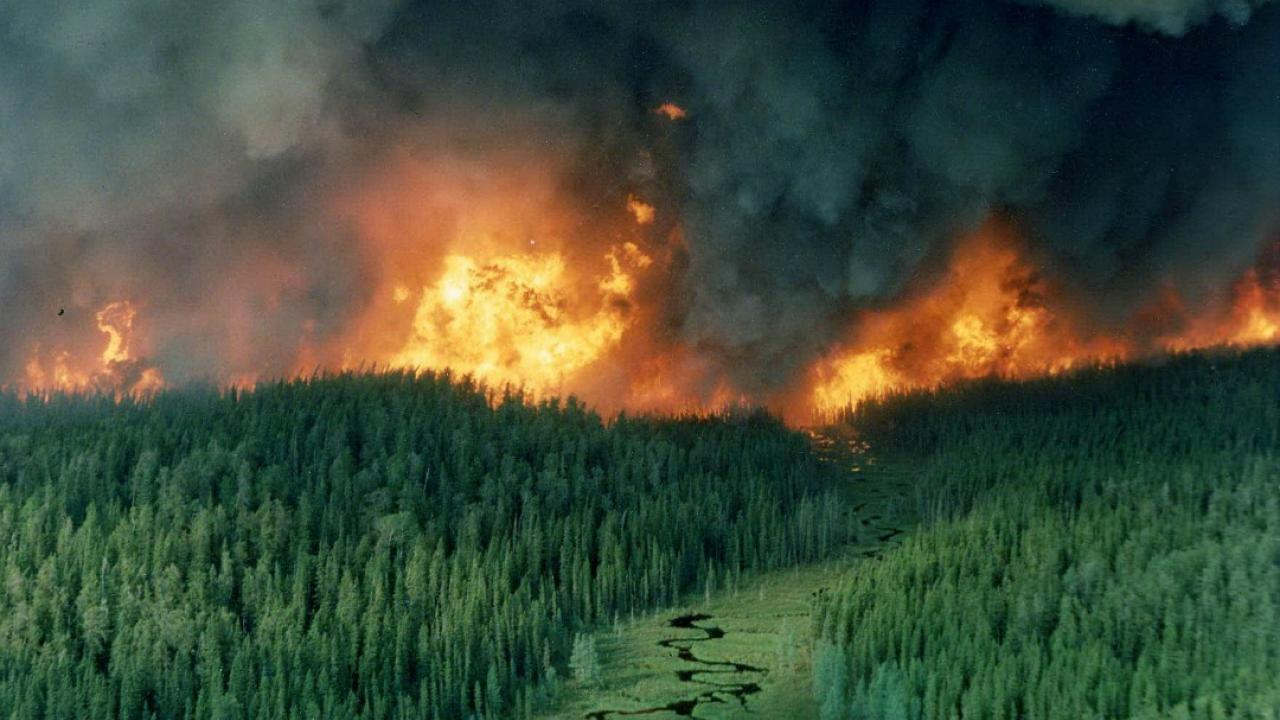

In [ ]:
# View image size 
from PIL import Image

im = Image.open('FIRE-SMOKE-DATASET/Test/Fire/image_0.jpg')
width, height = im.size
print("Image folder is unzipped and a sample image has a size of:", height, width)

In [ ]:
files = glob.glob('FIRE-SMOKE-DATASET/**/**/*.jpg', recursive=True)
neutral_files = [fn for fn in files if 'Neutral' in fn]
smoke_files = [fn for fn in files if 'Fire' in fn]
fire_files = [fn for fn in files if 'Smoke' in fn]

len(neutral_files), len(smoke_files) , len(fire_files)

# Create the training, validation and test sets of images.

### Training data teaches the model what to look for.

### Validation data quizes the model to see how accurate it is.

### Test data allows the model to be evaluated using images it has never seen.

In [ ]:
files = glob.glob('FIRE-SMOKE-DATASET/Train/**/*.jpg', recursive=True)

neutral_files_train = [ fn for fn in files if 'Neutral' in fn]
smoke_files_train = [ fn for fn in files if 'Fire' in fn]
fire_files_train = [ fn for fn in files if 'Smoke' in fn]

len(neutral_files_train), len(smoke_files_train) , len(fire_files_train)



In [ ]:
files = glob.glob('FIRE-SMOKE-DATASET/Test/**/*.jpg', recursive=True)

neutral_files_val = [fn for fn in files if 'Neutral' in fn]
smoke_files_val = [fn for fn in files if 'Fire' in fn]
fire_files_val = [fn for fn in files if 'Smoke' in fn]

len(neutral_files_val), len(smoke_files_val) , len(fire_files_val)


In [ ]:
files = glob.glob('fire-smoke-neutral-inference-images/**/*.jpg', recursive=True)

neutral_files_test = [fn for fn in files if 'Neutral' in fn]
smoke_files_test = [fn for fn in files if 'Fire' in fn]
fire_files_test = [fn for fn in files if 'Smoke' in fn]

len(neutral_files_test), len(smoke_files_test) , len(fire_files_test)


In [ ]:
neutral_train = np.random.choice(neutral_files, size=557, replace=False)
smoke_train = np.random.choice(smoke_files, size=925, replace=False)
fire_train = np.random.choice(fire_files, size=925, replace=False)
len(neutral_train), len(smoke_train) , len(fire_train)


In [ ]:
neutral_val = np.random.choice(neutral_files_val, size=125, replace=False)
smoke_val = np.random.choice(smoke_files_val, size=102, replace=False)
fire_val = np.random.choice(fire_files_val, size=116, replace=False)
len(neutral_val) , len(smoke_val) , len(fire_val)

In [ ]:
neutral_test = np.random.choice(neutral_files_test, size=84, replace=False)
smoke_test = np.random.choice(smoke_files_test, size=80, replace=False)
fire_test = np.random.choice(fire_files_test, size=69, replace=False)
len(neutral_test) , len(smoke_test) , len(fire_test)


In [ ]:
print('Data Sizes:   Training Validation Test')
print('Neutral datasets: ', neutral_train.shape,  neutral_val.shape, neutral_test.shape)
print('Smoke datasets:   ', smoke_train.shape,  smoke_val.shape, smoke_test.shape)
print('Fire datasets:    ', fire_train.shape,  fire_val.shape, fire_test.shape)

In [ ]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

In [ ]:
train_files = np.concatenate([ neutral_train , smoke_train , fire_train])
validate_files = np.concatenate([ neutral_val , smoke_val , fire_val])
test_files = np.concatenate([ neutral_test , smoke_test , fire_test])

In [ ]:
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

# This will sort the images into three sets. Smoke, Fire and Neutral.

 You will have a chance to give them a unique title.

In [ ]:
for idx, fn in enumerate(train_files):
    shutil.copy(fn, train_dir + '/' + str(fn.split('/')[-2]) + '_' + str(fn.split('/')[-1]))

In [ ]:
for fn in validate_files:
    shutil.copy(fn, val_dir + '/' + str(fn.split('/')[-2]) + '_' + str(fn.split('/')[-1]))

In [ ]:
for fn in test_files:
    shutil.copy(fn, test_dir + '/' + str(fn.split('/')[-2]) + '_' + str(fn.split('/')[-1]))
    

In [ ]:
IMG_DIM = (224,224)
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('_')[0].strip() for fn in train_files] #   

In [ ]:
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('_')[0].strip() for fn in validation_files]
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

In [ ]:
test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('_')[0].strip() for fn in test_files]
print('test dataset shape:', test_imgs.shape )

In [ ]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [ ]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=45,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
labels = ["Fire" , "Neutral" , "Smoke"]

<h3 align="left"> In order to train a good model we have to show it as many different images as we can find, but if we need to have a robust model we can use image augmentation. </h3>

<h4 align="left"> Image augmentation will zoom, rotate, shift and even flip an image to create variation.</h4> 

<h4 align="left">You will be asked to choose a label for the final model based on the pictures.</h4> 

<h5 align="left">The images fall into three catagories: smoke, fire or neutral.</h5> 

In [ ]:
img_id = train_labels.index('Fire')
fire_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
fire = [next(fire_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
# print('Labels:', [item[1][0] for item in fire])

l = [ax[i].imshow(fire[i][0][0]) for i in range(0,5)]

<h4 align="center">The image above is a sample of an image from one of the classes in our model.</h4>

In [ ]:
labels[0]= (input("What is your label for this group of images?  (Press Enter when done) "))

In [ ]:
img_id = train_labels.index('Neutral')
neutral_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
neutral= [next(neutral_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
# print('Labels:', [item[1][0] for item in neutral])
l = [ax[i].imshow(neutral[i][0][0]) for i in range(0,5)]

<h4 align="center">The image above is a sample of an image from one of the classes in our model.</h4>

In [ ]:
labels[1]= (input("What is your label for this group of images?  (Press Enter when done) "))

In [ ]:
img_id = train_labels.index('Smoke')
smoke_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
smoke = [next(smoke_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
# print('Labels:', [item[1][0] for item in smoke])
l = [ax[i].imshow(smoke[i][0][0]) for i in range(0,5)]

<h4 align="center">The image above is a sample of an image from one of the classes in our model.</h4>

In [ ]:
labels[2]= (input("What is your label for this group of images?  (Press Enter when done) "))

# We don't have to always make our own model from scratch.

 There are a lot of already proven models that we can repurpose for what we need.


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
import tensorflow.keras 
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications import mobilenet, vgg16
from tensorflow.keras.models import Model, load_model , Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

input_shape = (224, 224, 3)

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)



output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False

    
#pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


input_shape = vgg_model.output_shape[1]
input_shape


vgg_model.trainable = False

print('This is the model that we are going to use. It has over 14.7 million parameters.')
vgg_model.summary()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=False, 
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=2)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=2)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
print('But we are going to add some more layers at the end. Now we have over 27.8 million parameters.')
model.summary()             

### This model can take 740 seconds (or longer) to run without GPU acceleration...and that's just for 1 epoch!! This is running 50 in far less time.

In [ ]:
start_time = time.time()
history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=50,
                              validation_data=val_generator, validation_steps=100, 
                              verbose=1)  
print("--- %s seconds ---" % (time.time() - start_time))

<h4 align="center">The model will take a few minutes to train. Step 199 will take extra time as the model passes through the validation data.</h4>

In [ ]:
team = (input("What is your name?  (Press Enter when done)  "))

In [ ]:
model_name = 'smoke_fire_cloud_' + str(team.strip()) + '.h5'

model.save(model_name)

## Now we have a machine learning model help us to detect smoke and fire.

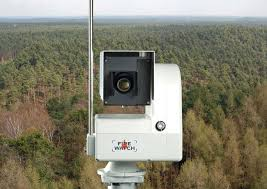




In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
%matplotlib inline

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('smoke_fire_vgg_small.h5' ) 


In [ ]:
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]

DATASET_PATH = test_files                          
LABEL_PATH = test_labels                             

# labels = ["Fire" , "Neutral" , "Smoke"]

# This function prepares a random batch from the dataset
def load_batch(dataset_df, batch_size = 25):
    batch_df = dataset_df.loc[np.random.permutation(np.arange(0,
                                                              len(dataset_df)))[:batch_size],:]
    return batch_df
    
# This function plots sample images in specified size and in defined grid
def plot_batch(images_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(16, 16)
#     print ( test_files[ batch_df[0].index[0] ] ,  test_labels[ batch_df[0].index[0] ]  )
    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            actual_label =  test_labels[ batch_df[0].index[img_idx] ]
            # load an image from file
            image = load_img(test_files[ batch_df[0].index[img_idx] ], target_size=(224, 224))
            # convert the image pixels to a numpy array
            image = img_to_array(image)
            # reshape data for the model
            ax[i][j].imshow(image/255. )
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # prepare the image for the VGG model
            image = preprocess_input(image)
            # load the model
            # predict the probability across all output classes
            prediction = model.predict(image)
            actual_label = test_labels[ batch_df[0].index[img_idx] ]
            label_idx = np.argmax(prediction)
            predicted_label = labels[label_idx]
            conf = round(prediction[0][label_idx], 2)
            ax[i][j].set_title('Actual: '+actual_label+'\n Pred: '+predicted_label + '    Conf: ' +str(conf) , fontsize = 8)
            img_path =  test_files[ batch_df[0].index[img_idx]]
            img_idx += 1


            
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

In [ ]:
# load dataset and visualize sample data
# pd.DataFrame(test_labels) 
dataset_df =  pd.DataFrame(test_labels)  
batch_df = load_batch(dataset_df, batch_size=36)

In [ ]:
plot_batch(batch_df, grid_width=6, grid_height=6, im_scale_x=96, im_scale_y=96)

In [ ]:
# Verification 

import ww
ww = ww.WatsonWarriors()
 
ww.assertStatement(0,os.path.isfile(model_name))

In [ ]:
# Paste verification code below.
